<a href="https://colab.research.google.com/github/KacperGrodecki/nieruchomosci-mazowieckie/blob/main/mazowieckie_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn import svm
import pandas as pd
import numpy as np
np.random.seed(7)
from google.colab import drive
import seaborn as sns
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
#from otoDomScraper import daneDomu
#from random import randrange
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statistics
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.decomposition import FastICA

Mounted at /content/drive


In [2]:
def toNum2(txt):
    if type(txt) is int:
        return txt
    elif (type(txt) is str):
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2:
            return 1000 * int(digs[0]) + int(digs[1])
        elif len(digs) == 3:
            return 1000000 * int(digs[0]) + 1000 * int(digs[1]) + int(digs[0])

    #   return int(digs)


def toNum1(txt):
    if type(txt) is str:
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2 and (txt[1] != ' '):
            return int(digs[0]) + 0.01 * int(digs[1])
        elif len(digs) == 3:
            return 1000 * int(digs[0]) + int(digs[1]) + 0.001 * int(digs[2])
        elif (type(txt) is str) and (txt[1] == ' '):
            digs = re.findall(r'\d+', txt)
            return 1000 * int(digs[0]) + int(digs[1])
    else:
        return txt


def toNum3(txt):
    if type(txt) == int:
        return txt
    return int(re.findall(r'\d+', txt)[0])

def pietra(txt):
    if type(txt) is str:
        if '0' in txt:
            return 0
        if '1' in txt:
            return 1
        elif '2' in txt:
            return 2
        elif '3' in txt:
            return 3
        elif 'parterowy' in txt:
            return 0
    else:
        return txt

def cities(x):
    dist=x.split()[4]
    #city=x.split()[5]
    if dist=='warszawski':
        return x.split()[6]
    elif dist in ['Warszawa','Radom','Płock','Siedlce']:
        return dist
    else:
        try:
            return x.split()[5]
        except:
            return 'unknown'

def region(x):
    if x.split()[4]=='Warszawa':
        try:
            return x.split()[5]
        except:
            return ''
    else:
        return ''

In [3]:
def makeDataFrame(file):
    dfMazowieckie=pd.read_csv(file,index_col=0)
    concat=dfMazowieckie
    concat['powierzchnia_corr'] = concat['powierzchnia'].apply(lambda x: toNum1(x))
    concat['powierzchniaDzialki_corr'] = concat['powierzchniaDzialki'].apply(lambda x: toNum2(x))
    concat['cena_corr'] = concat['cena'].apply(lambda x: toNum2(x))
    concat['rokBudowy_corr'] = concat['rokBudowy'].apply(lambda x: toNum3(x))
    concat['cena/m'] = concat['cena_corr'] / concat['powierzchnia_corr']
    concat['lPieter_crr'] = concat['lPieter'].apply(lambda x: pietra(x))
    concat = concat[concat['powierzchnia_corr'] > 0]
    concat = concat[concat['cena_corr'] > 0]
    concat['lPokoi'] = concat['lPokoi'].apply(lambda x: toNum3(x))
    concat['districts']=concat['dzielnica'].apply(lambda x: x.split()[4])
    cities_corr=concat['dzielnica'].apply(lambda x: cities(x))
    concat['cities_corr']=cities_corr
    region_corr=concat['dzielnica'].apply(lambda x: region(x))
    concat['region_corr']=region_corr
    concat_dropped = concat.drop(['dzielnica', 'powierzchnia', 'powierzchniaDzialki', 'lPieter', 'cena', 'cena_corr',], axis=1)
    concat_dropped['rokBudowy'] = concat_dropped['rokBudowy'].replace(to_replace=0, value=1990)
    concat_dropped['rokBudowy'] = concat_dropped['rokBudowy'].astype('int')
    concat_dropped = concat_dropped.fillna(0)
    concat_dropped = concat_dropped[concat_dropped['cena/m'] < 20000]
    concat_dropped['cena/m'].hist(bins=200)
    concat_dropped = pd.get_dummies(concat_dropped, columns=['rodzajZabudowy', 'materialBudynku', 'stanWykonczenia', 'okna', 'rynek',
                                             'cities_corr','districts','region_corr'])
    return concat_dropped

In [4]:
filename='/content/drive/My Drive/domy mazowieckie/dfMazowieckie.csv'

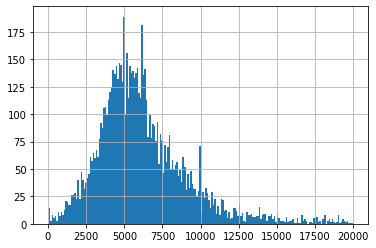

In [5]:
concat_dropped=makeDataFrame(filename)

In [11]:
concat_dropped.head()

,lPokoi,rokBudowy,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,rodzajZabudowy_0,rodzajZabudowy_bliźniak,rodzajZabudowy_dworek/pałac,rodzajZabudowy_gospodarstwo,rodzajZabudowy_kamienica,rodzajZabudowy_szeregowiec,rodzajZabudowy_wolnostojący,materialBudynku_0,materialBudynku_beton,materialBudynku_beton komórkowy,materialBudynku_cegła,materialBudynku_drewno,materialBudynku_inne,materialBudynku_keramzyt,materialBudynku_pustak,materialBudynku_silikat,stanWykonczenia_0,stanWykonczenia_do remontu,stanWykonczenia_do wykończenia,stanWykonczenia_do zamieszkania,stanWykonczenia_stan surowy otwarty,stanWykonczenia_stan surowy zamknięty,okna_0,okna_aluminiowe,okna_brak,okna_drewniane,okna_plastikowe,rynek_pierwotny,rynek_wtórny,cities_corr_Adamowice,cities_corr_Adamowizna,cities_corr_Adamowo,cities_corr_Adampol,...,districts_przasnyski,districts_przysuski,districts_pułtuski,districts_płocki,districts_płoński,districts_radomski,districts_siedlecki,districts_sierpecki,districts_sochaczewski,districts_sokołowski,districts_szydłowiecki,districts_warszawski,districts_wołomiński,districts_wyszkowski,districts_węgrowski,districts_zwoleński,districts_łosicki,districts_żuromiński,districts_żyrardowski,region_corr_,region_corr_Aleksandrów,region_corr_Bemowo,region_corr_Białołęka,region_corr_Bielany,region_corr_Mokotów,region_corr_Ochota,region_corr_Praga-Południe,region_corr_Praga-Północ,region_corr_Rembertów,region_corr_Targówek,region_corr_Ursus,region_corr_Ursynów,region_corr_Wawer,region_corr_Wesoła,region_corr_Wilanów,region_corr_Wola,region_corr_Włochy,region_corr_ul.,region_corr_Śródmieście,region_corr_Żoliborz
0,6,2019,320.00,1000,2019,6062.503125,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,5,2021,154.00,750,2021,5186.363636,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1950,80.00,2356,1950,5612.500000,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2022,152.91,220,2022,4250.866523,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2020,106.00,960,2020,2924.528302,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
!pip install tensorflow_decision_forests

     |████████████████████████████████| 6.3 MB 4.4 MB/s 


In [7]:
!pip install wurlitzer

In [8]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [9]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)


Found TensorFlow Decision Forests v0.1.8


In [10]:
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(concat_dropped)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))


5435 examples in training, 2388 examples for testing.


In [37]:
from tensorflow_decision_forests.tensorflow import core as tf_core

In [40]:
#train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
Task = tf_core.Task
train_ds=tfdf.keras.pd_dataframe_to_tf_dataset(
    train_ds_pd,
    label='cena/m',
    task=Task.REGRESSION
)

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_ds_pd,
    label='cena/m',
    task=Task.REGRESSION
)

In [42]:
#%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(Task.REGRESSION)

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=["accuracy"])

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
  model_1.fit(x=train_ds)


ValueError: ignored